In [1]:
from glob import glob
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
sc.set_figure_params(dpi=300, dpi_save=300)
plt.rcParams['font.family'] = 'DejaVu Sans'

In [2]:
#Read .h5ad files with with Seurat annotations
files = sorted(glob('../data/h5_filt_seurat/*.h5ad'))
# files = [files[-2]]
adata_list = [sc.read_h5ad(file) for file in files]
    
for adata in adata_list:
    adata.obs.rename(columns={"predicted.celltype": "Seurat"}, inplace=True)


In [3]:
#Read CoDi and CoDi_dist annotations from .csv files
a_files = sorted(glob('../data/annotations/*.csv'))
# a_files = [a_files[-2]]
annotation_list = [pd.read_csv(file, index_col="cell_id") for file in a_files]

all_cell_types = ['B cell', 'CD14+ monocyte', 'CD4+ T cell', 'Cytotoxic T cell', 'Natural killer cell']


# Merge CoDI and CoDi_dist annotations with the corresponding AnnData objects
# Ensure that the indices of the annotations match the indices of the AnnData objects
for i, adata in enumerate(adata_list):
    adata.obs = pd.merge(adata.obs, annotation_list[i], left_index=True, right_index=True, how="inner")
    adata_list[i] = adata[adata.obs['CoDi_dist'].isin(all_cell_types)].copy()
    adata.obs['CoDi_dist'] = adata.obs['CoDi_dist'].astype('category')
    # Ensure CoDi_dist is categorical and trim unused categories
    adata.obs['CoDi_dist'] = (
        adata.obs['CoDi_dist']
        .astype('category')
        .cat.remove_unused_categories()
    )
    # print(adata.obs['CoDi_dist'].cat.categories)
    # print(len(adata.obs['CoDi_dist'].cat.categories))
    # print(adata.uns.get('CoDi_dist_colors'))
    # print(len(adata.uns.get('CoDi_dist_colors', [])))


In [4]:
set(adata_list[0].obs['CoDi_dist'])

{'B cell',
 'CD14+ monocyte',
 'CD4+ T cell',
 'Cytotoxic T cell',
 'Natural killer cell'}

✅ Saved: pseudotime_umap_grid.pdf


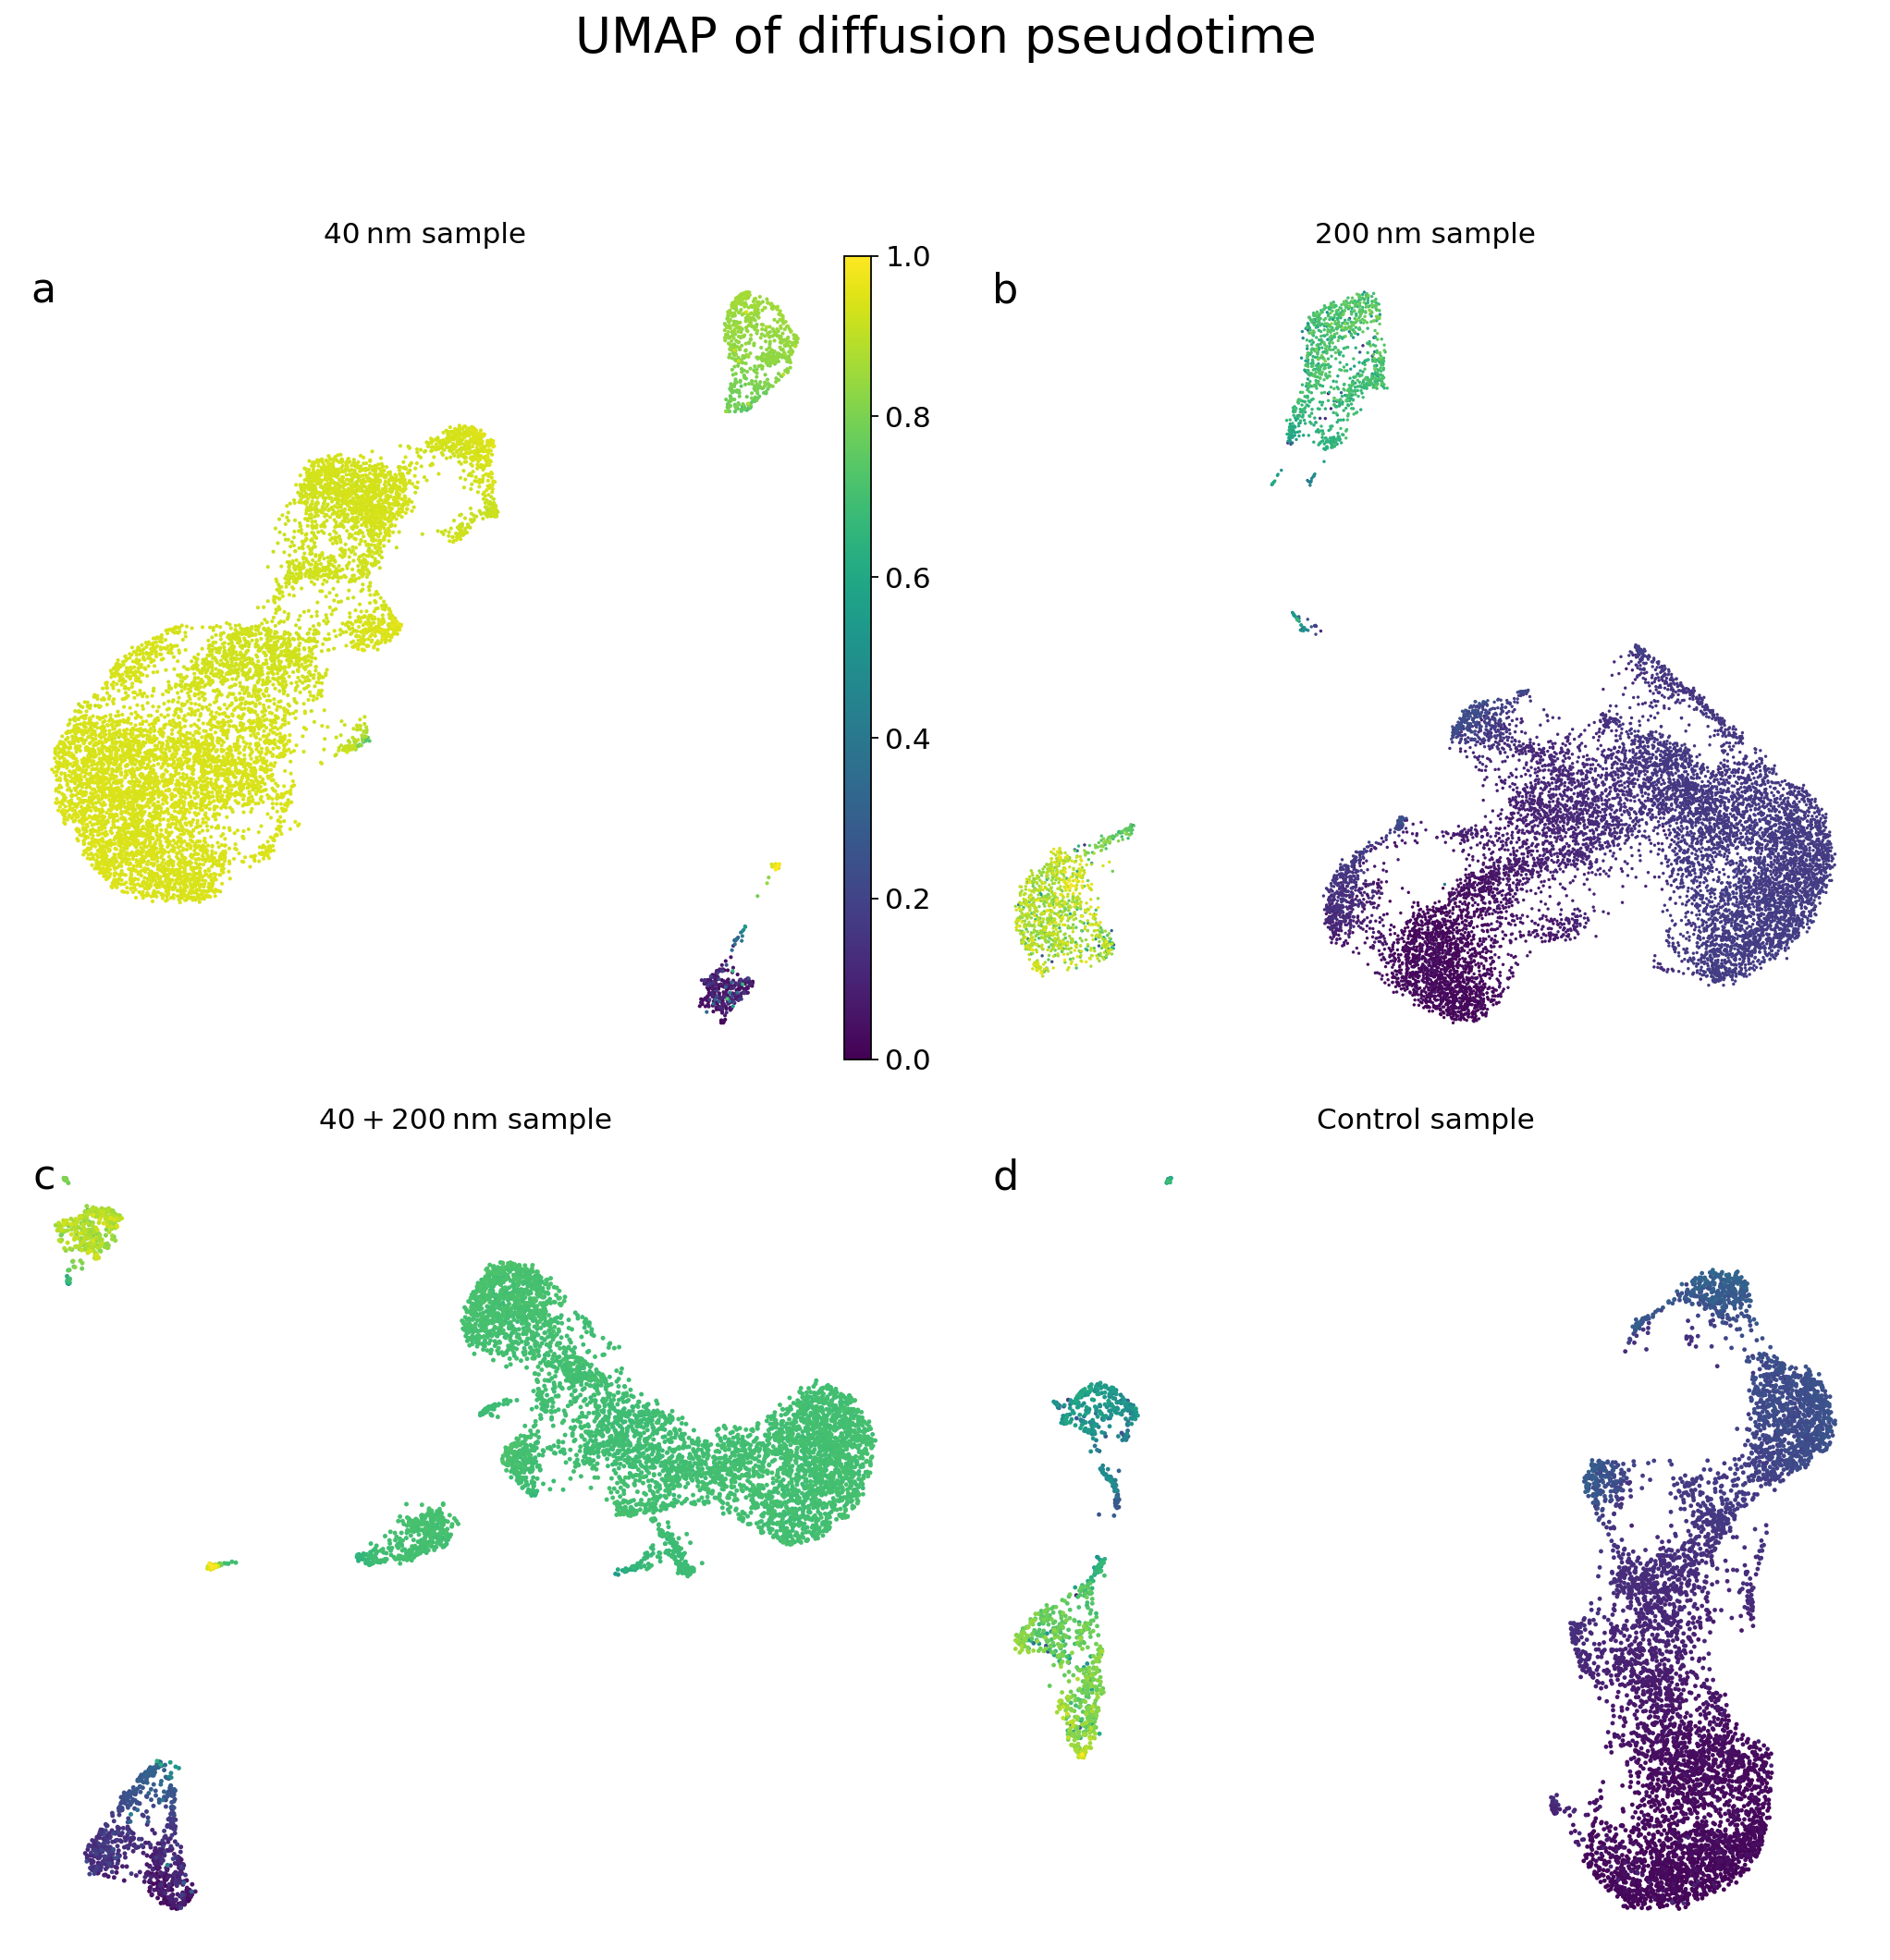

In [15]:
import scanpy as sc
import matplotlib.pyplot as plt
import time

sample_labels = ["40 nm", "200 nm", "40 + 200 nm", "Control"]

# ---------- SETTINGS ----------
sc.settings.verbosity = 0
sc.settings.set_figure_params(figsize=(4, 4))

fig_pt, axes_pt = plt.subplots(2, 2, figsize=(13, 13))
axes_pt = axes_pt.flatten()
labels_subplots = ['a', 'b', 'c', 'd']

for idx, (adata, label) in enumerate(zip(adata_list, sample_labels)):
    ax = axes_pt[idx]

    # neighbours → paga → dpt (as before)
    sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
    sc.tl.paga(adata, groups="CoDi_dist")
    root_cell = adata.obs_names[adata.obsm['X_umap'][:, 1].argmin()]
    adata.uns['iroot'] = adata.obs_names.get_loc(root_cell)
    sc.tl.dpt(adata, n_dcs=10)

    # ---------- UMAP coloured by pseudotime ----------
    sc.pl.umap(
        adata,
        color="dpt_pseudotime",
        ax=ax,
        title=f"{label} sample",
        show=False,
        colorbar_loc="right" if idx == 0 else None  # keep colour‑bar only for first panel
    )

    # ‑‑ tidy axis: remove ticks, labels, box
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

    # ‑‑ add neat subplot label
    ax.text(
        0.02, 0.98, labels_subplots[idx],
        transform=ax.transAxes,
        fontsize=20,
        va='top', ha='left'
    )

# ---------- overall figure title ----------
fig_pt.suptitle("UMAP of diffusion pseudotime", y=1.02, fontsize=24)

fig_pt.tight_layout(rect=[0, 0, 1, 0.97])  # leave space for main title
fig_pt.savefig("pseudotime_umap_grid.pdf", bbox_inches="tight")
print("✅ Saved: pseudotime_umap_grid.pdf")


✅ Saved: umap_paga_transitions.pdf


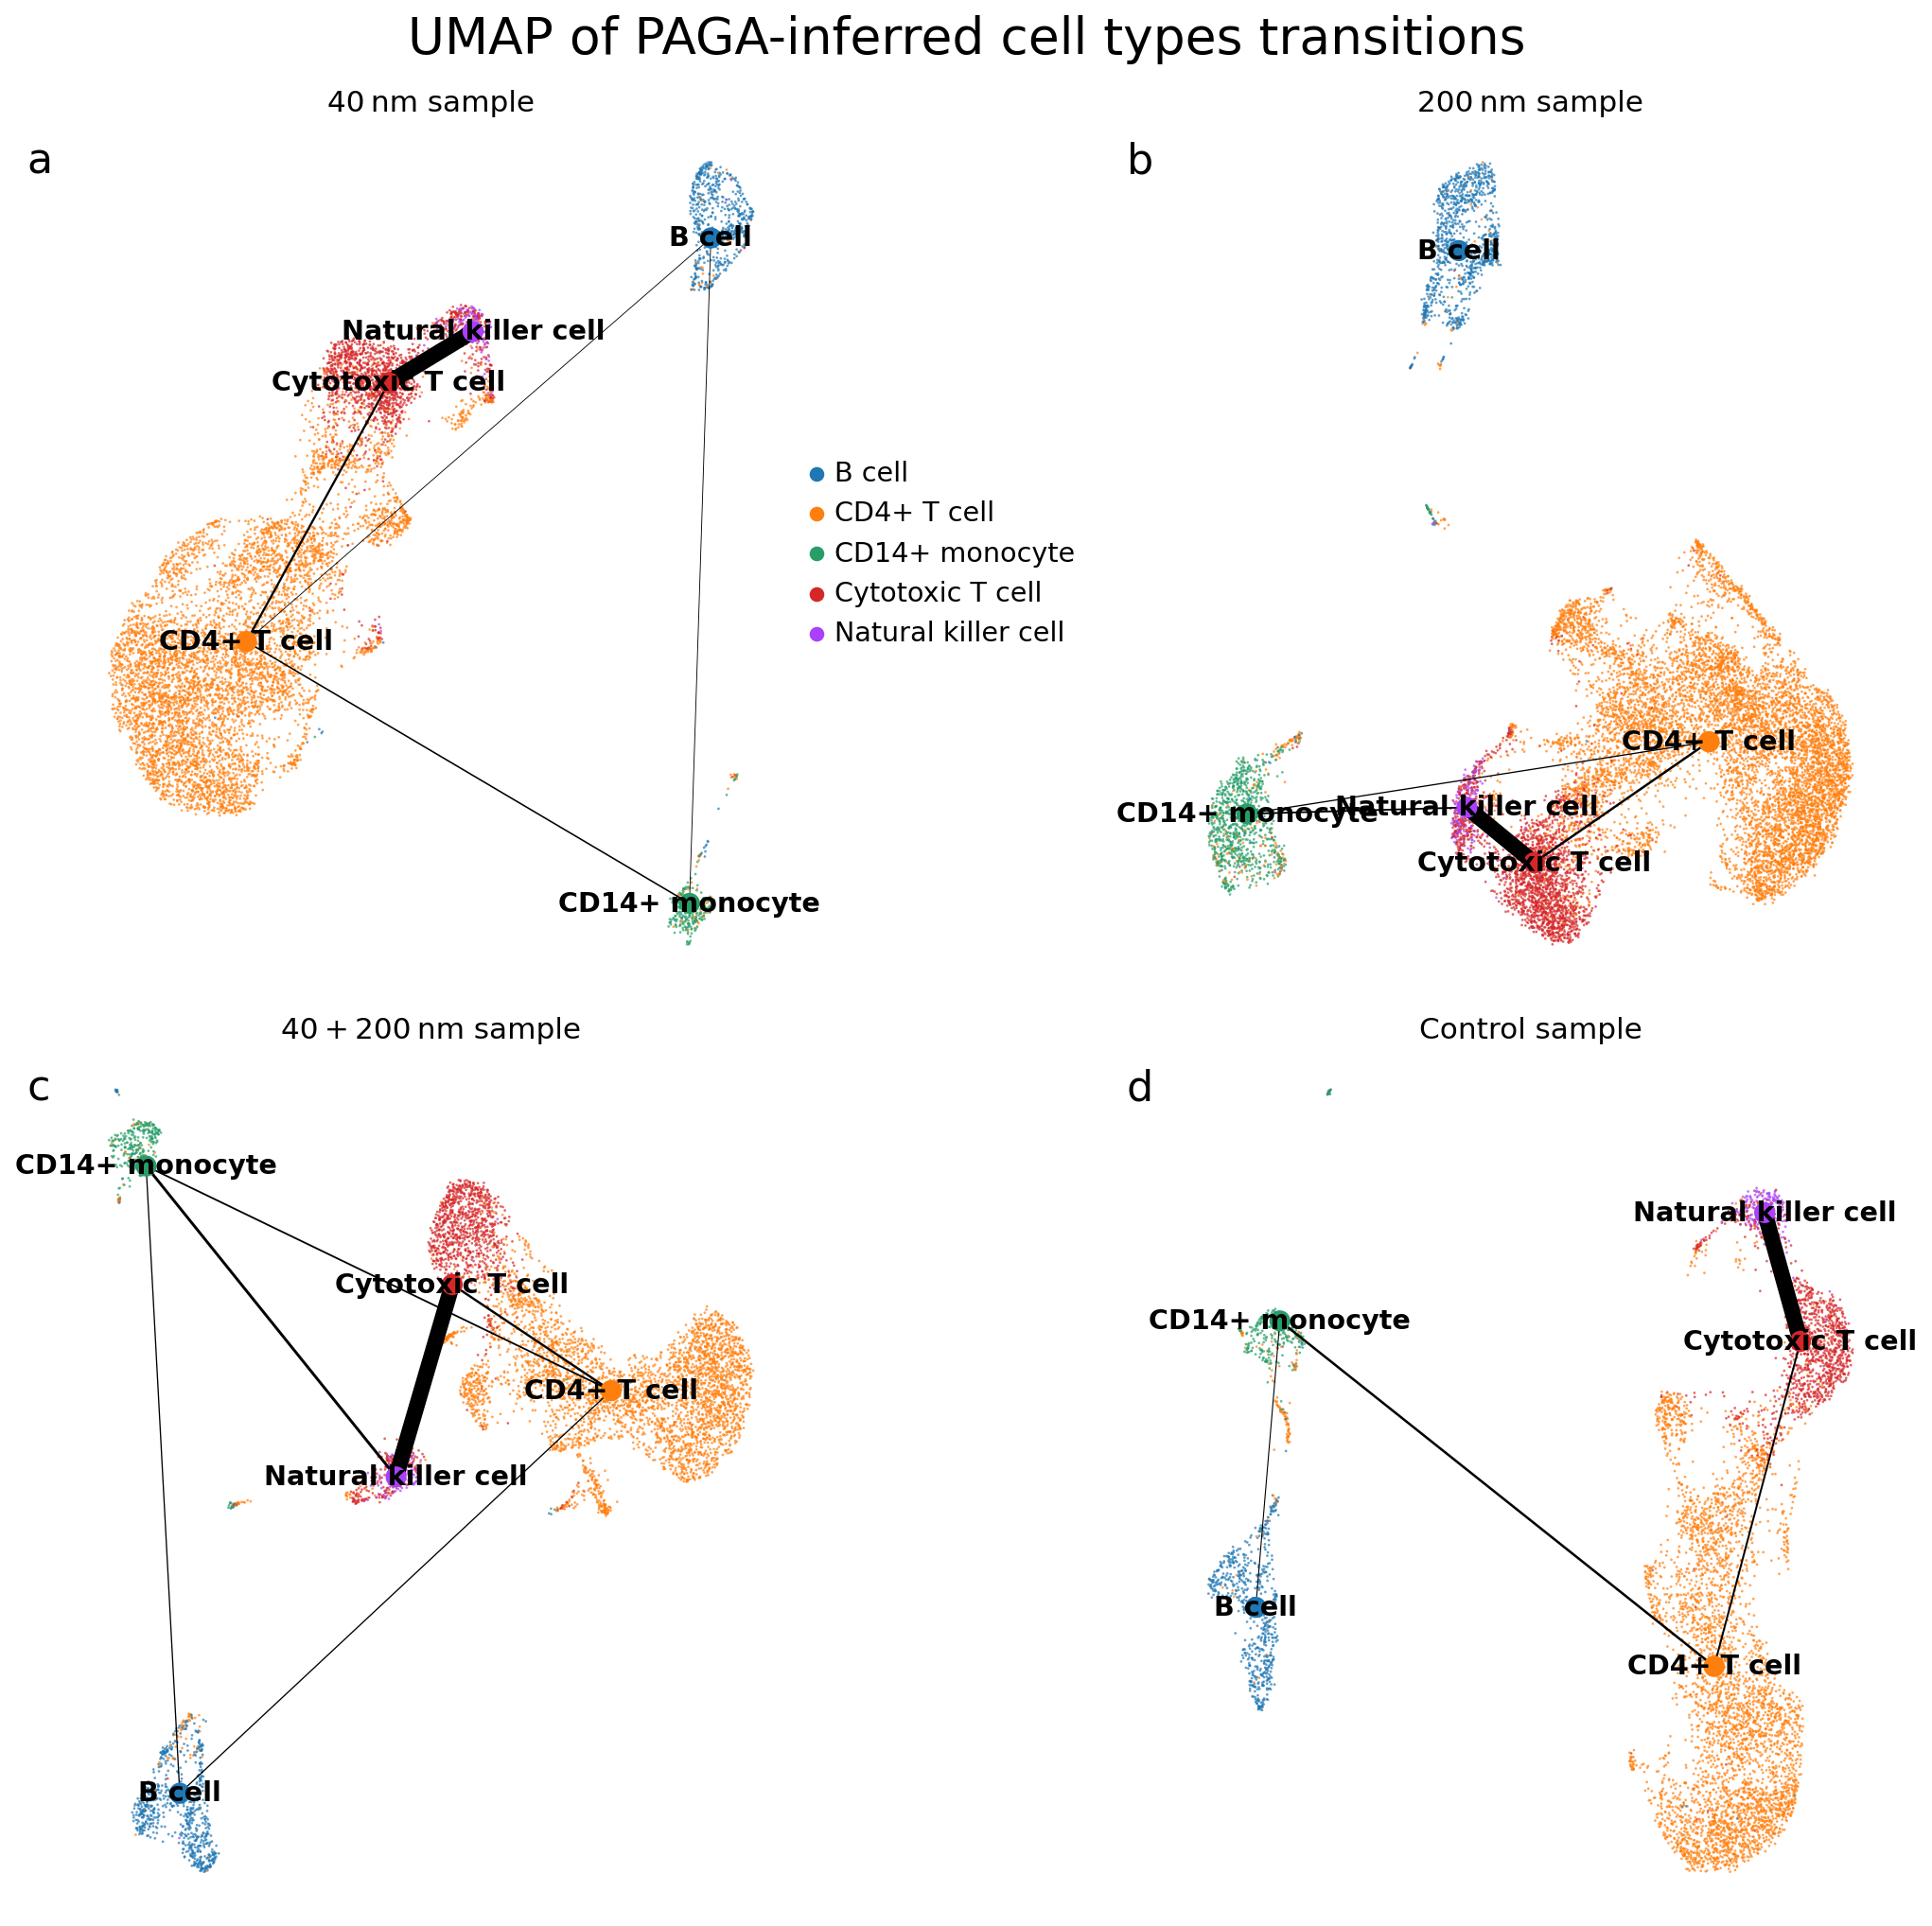

In [21]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np

# -------------------- PLOT PAGA TRAJECTORIES + CELL TYPES -----------------
fig, axes = plt.subplots(2, 2, figsize=(13, 13))
axes = axes.flatten()
labels_subplots = ['a', 'b', 'c', 'd']
for idx, (adata, label) in enumerate(zip(adata_list, sample_labels)):
    ax = axes[idx]

    # 1️⃣  Plot UMAP colored by CoDi_dist (cell types)
    sc.pl.umap(
        adata,
        color="CoDi_dist",
        ax=ax,
        show=False,
        alpha=0.7,
        size=6,
        title=f"{label} – cell types + PAGA",
        legend_loc='right margin' if idx == 0 else None  # Show legend only for first subplot
    )

    # 2️⃣  Compute cluster centroids in UMAP space
    cluster_labels = adata.obs["CoDi_dist"].cat.categories
    centroids = np.vstack([
        adata.obsm['X_umap'][adata.obs['CoDi_dist'] == cluster].mean(axis=0)
        for cluster in cluster_labels
    ])

    # 3️⃣  Plot PAGA graph (overlay)
    sc.pl.paga(
    adata,
    color='CoDi_dist',
    title=f'{label} sample',
    ax=ax,
    pos=centroids,
    show=False,
    threshold=0.05,
    frameon=False,
    node_size_scale=0.5,
    node_size_power=0.01,
    edge_width_scale=1)

    # Add subplot label (a, b, c, d) in upper-left corner
    ax.text(
        -0.07, 0.98, labels_subplots[idx],
        transform=ax.transAxes,
        fontsize=20,
        # fontweight='bold',
        va='top',
        ha='left'
    )
    # --- remove axis labels & ticks ---
    ax.set_xlabel("")
    ax.set_ylabel("")


fig.suptitle(
    "UMAP of PAGA-inferred cell types transitions",
    fontsize=24,
    # fontweight='bold'
)
fig.tight_layout()
fig.savefig("umap_paga_transitions.pdf", bbox_inches="tight")
print("✅ Saved: umap_paga_transitions.pdf")
